# Importing Necessary Libraries

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [54]:
try:
    if tf.test.gpu_device_name():
        physical_devices = tf.config.experimental.list_physical_devices('GPU')
        print('GPU active! -', physical_devices)
    else:
        print('GPU not active!')
except Exception as e:
    print('An error occurred while checking the GPU:', e)

GPU active! - [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Importing Dataset


* CN (Cognitively Normal): Individuals without cognitive impairment.
* MCI (Mild Cognitive Impairment): Individuals with a subtle decline in cognitive abilities that may or may not progress to more severe conditions.
* LMCI (Late Mild Cognitive Impairment): A stage within the MCI category, typically representing a later or more advanced phase of mild cognitive impairment.
* EMCI (Early Mild Cognitive Impairment): Another stage within the MCI category, indicating an earlier or less advanced phase of mild cognitive impairment.


There are 2352 images in the LMCI folder.
There are 860 images in the EMCI folder.
There are 1782 images in the MCI folder.
There are 1912 images in the CN folder.
The search has been completed.


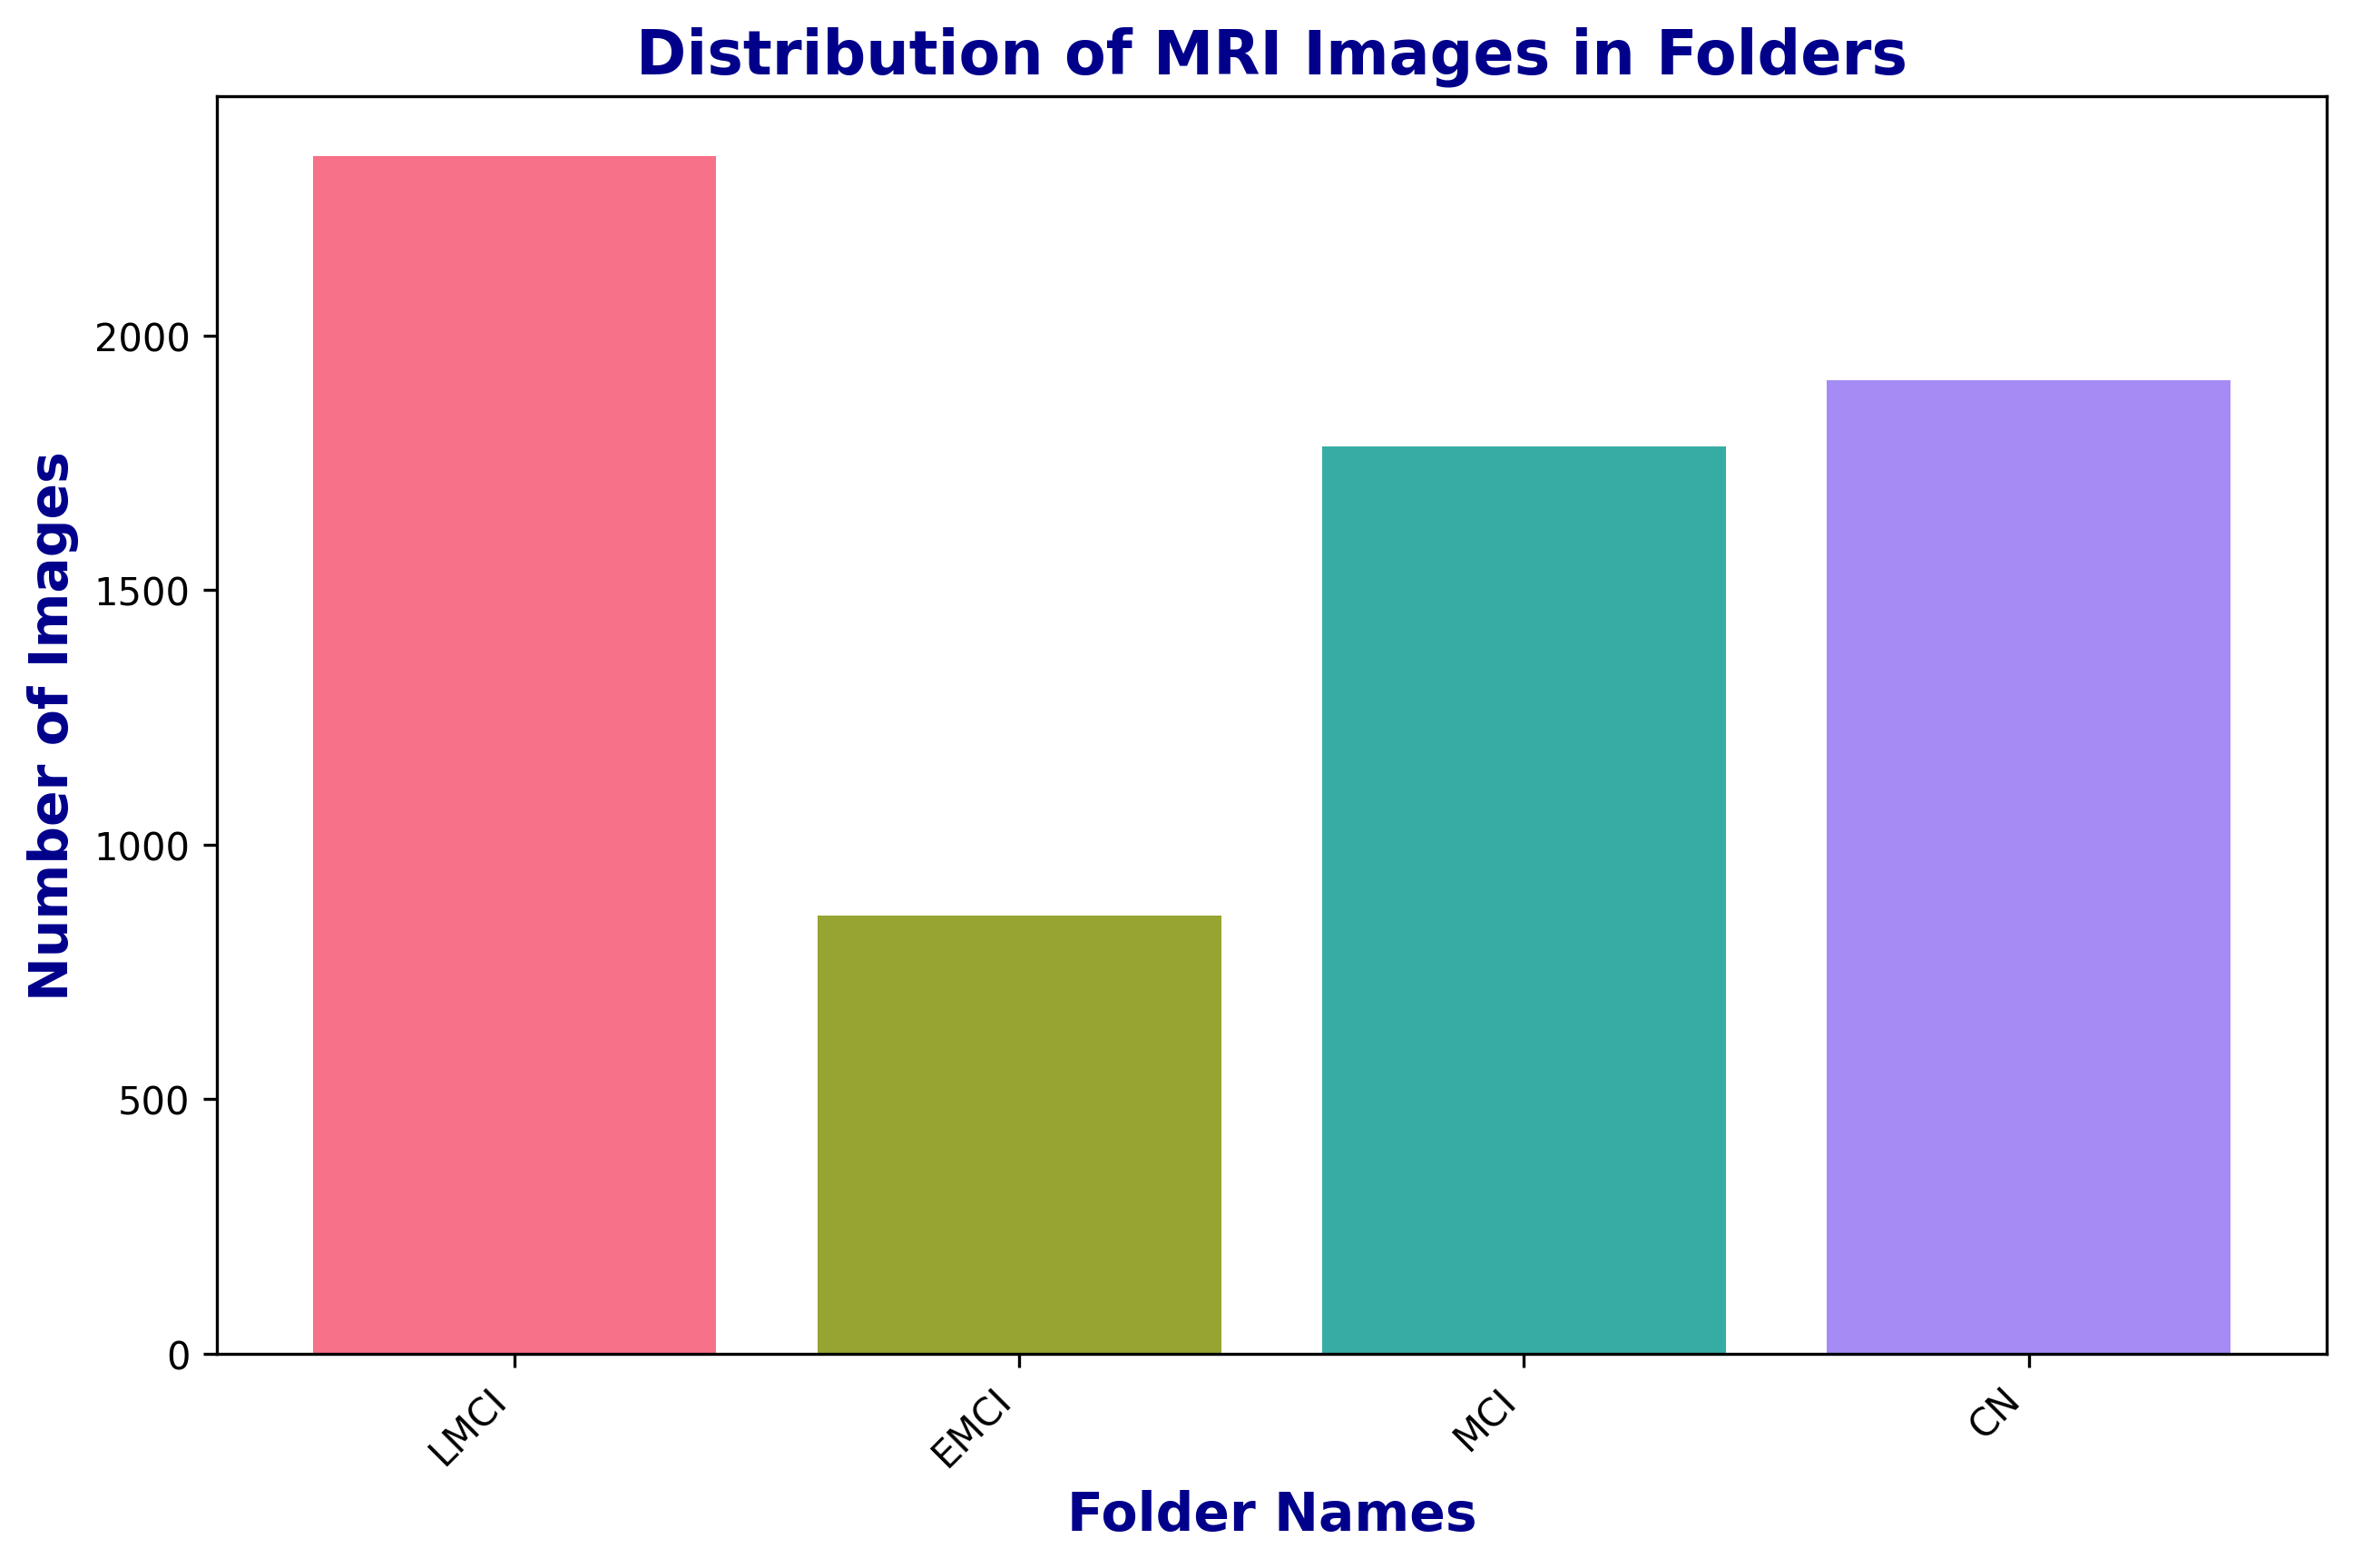

In [55]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

folder_path = '/kaggle/input/cognitive/MRI_Segmented_Augmented'
class_dist = {}
image_extensions = ['.jpg', '.jpeg', '.png']

def count_images_in_folder(dir_path):
    count = 0
    for filename in os.listdir(dir_path):
        file_ext = os.path.splitext(filename)[1].lower()

        if file_ext in image_extensions:
            count += 1
    return count

def analyze_folder_structure():
    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = count_images_in_folder(dir_path)
            class_dist[dir_name] = count
            print(f"There are \033[35m{count}\033[0m images in the {dir_name} folder.")
    print('\033[92m' + "The search has been completed." + '\033[0m')

def plot_distribution_bar_chart():
    keys = list(class_dist.keys())
    values = list(class_dist.values())

    colors = sns.color_palette("husl", len(keys))

    plt.bar(keys, values, color=colors)
    plt.xlabel('Folder Names', fontsize=14, fontweight="bold", color="darkblue")
    plt.ylabel('Number of Images', fontsize=14, fontweight="bold", color="darkblue")
    plt.title('Distribution of MRI Images in Folders', fontsize=16, fontweight="bold", color="darkblue")
    plt.xticks(rotation=45, ha='right')
    plt.show()

analyze_folder_structure()
plot_distribution_bar_chart()

<p style="color: black; background-color: lightsteelblue; border:2px solid black;">Let's see some samples for each class!</p>

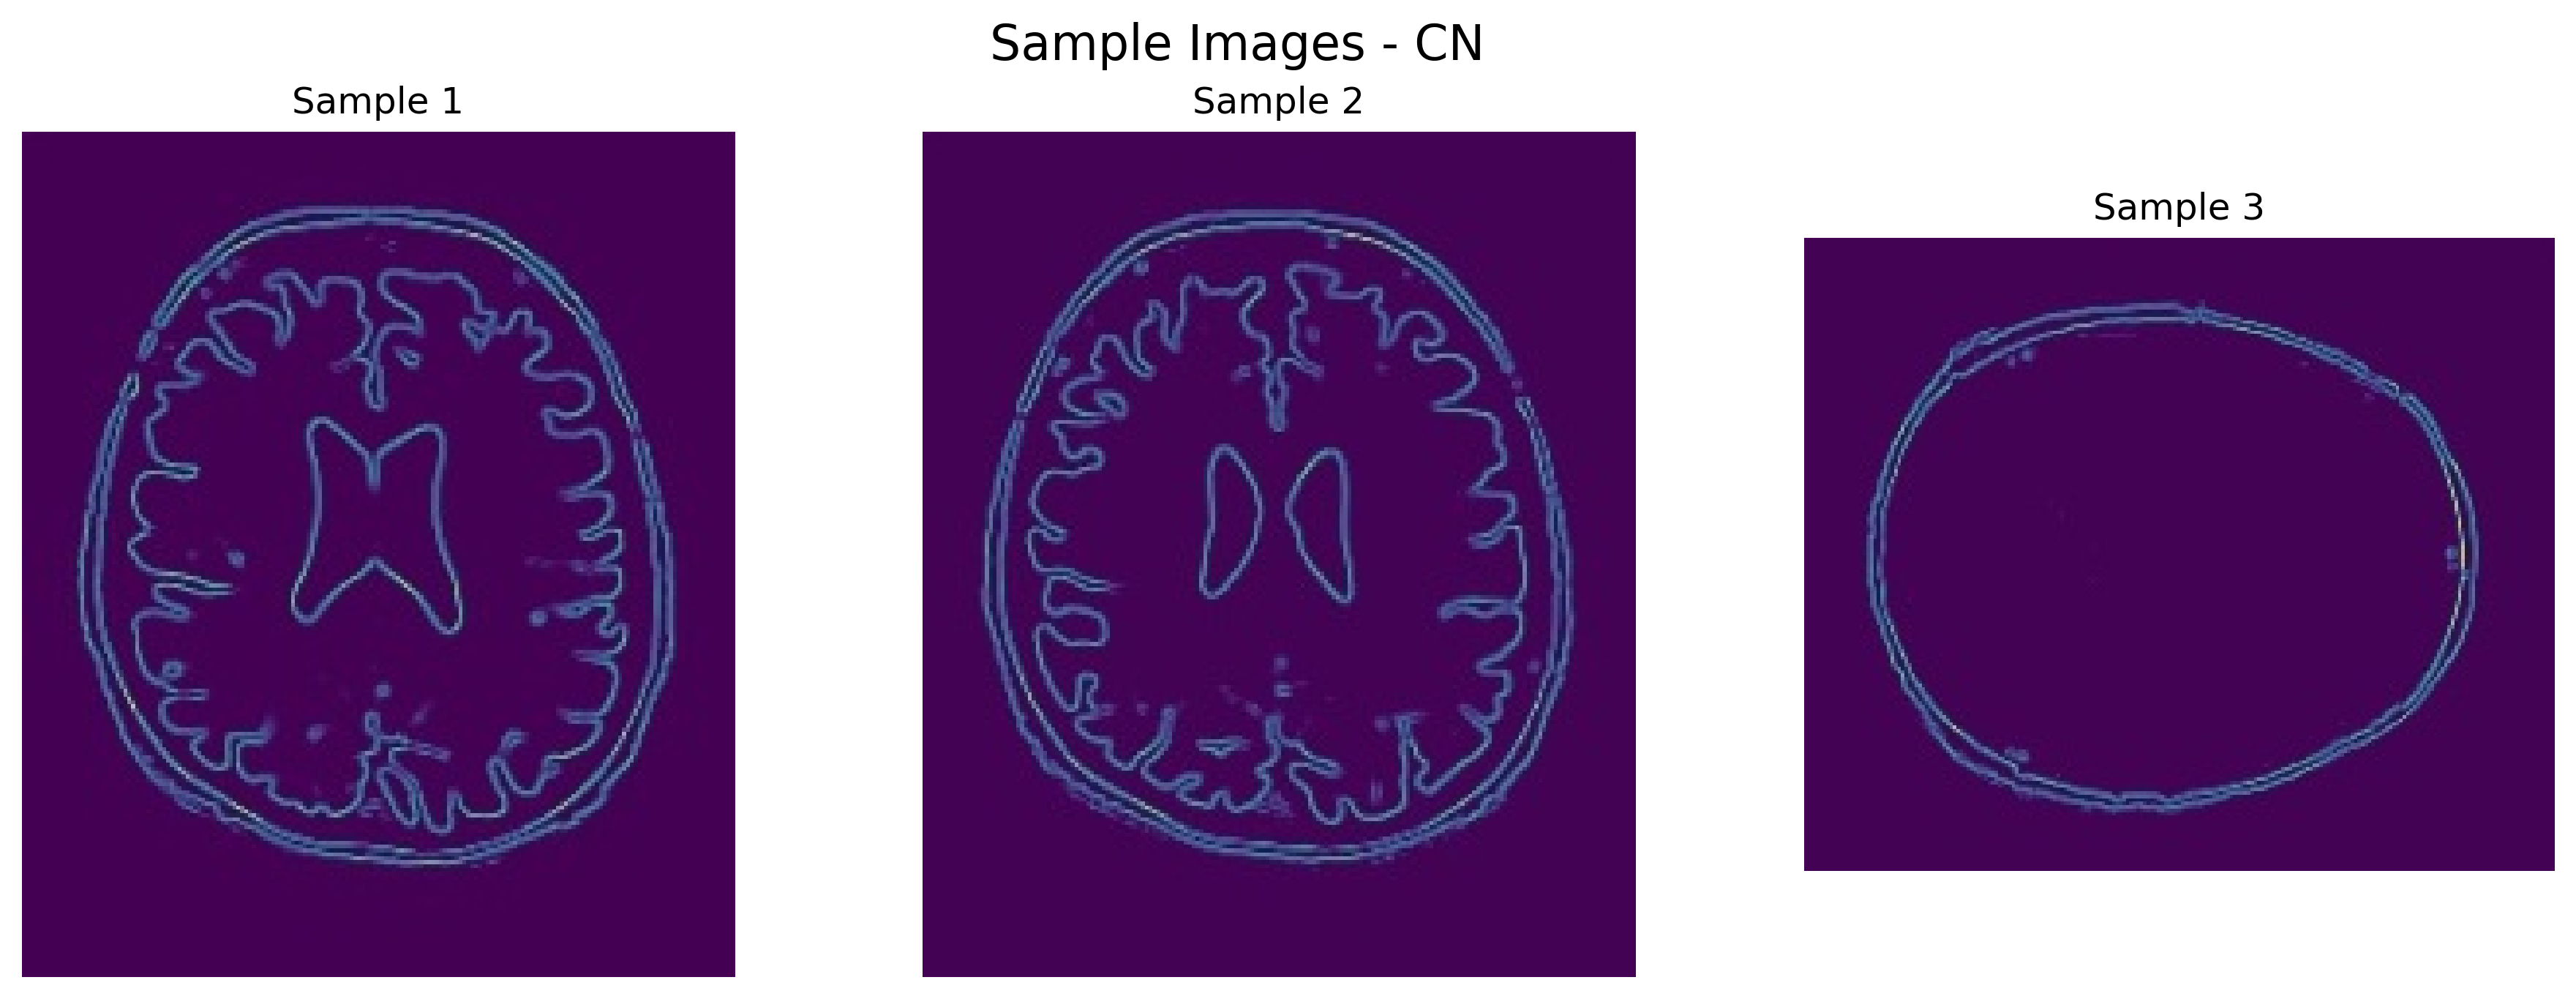

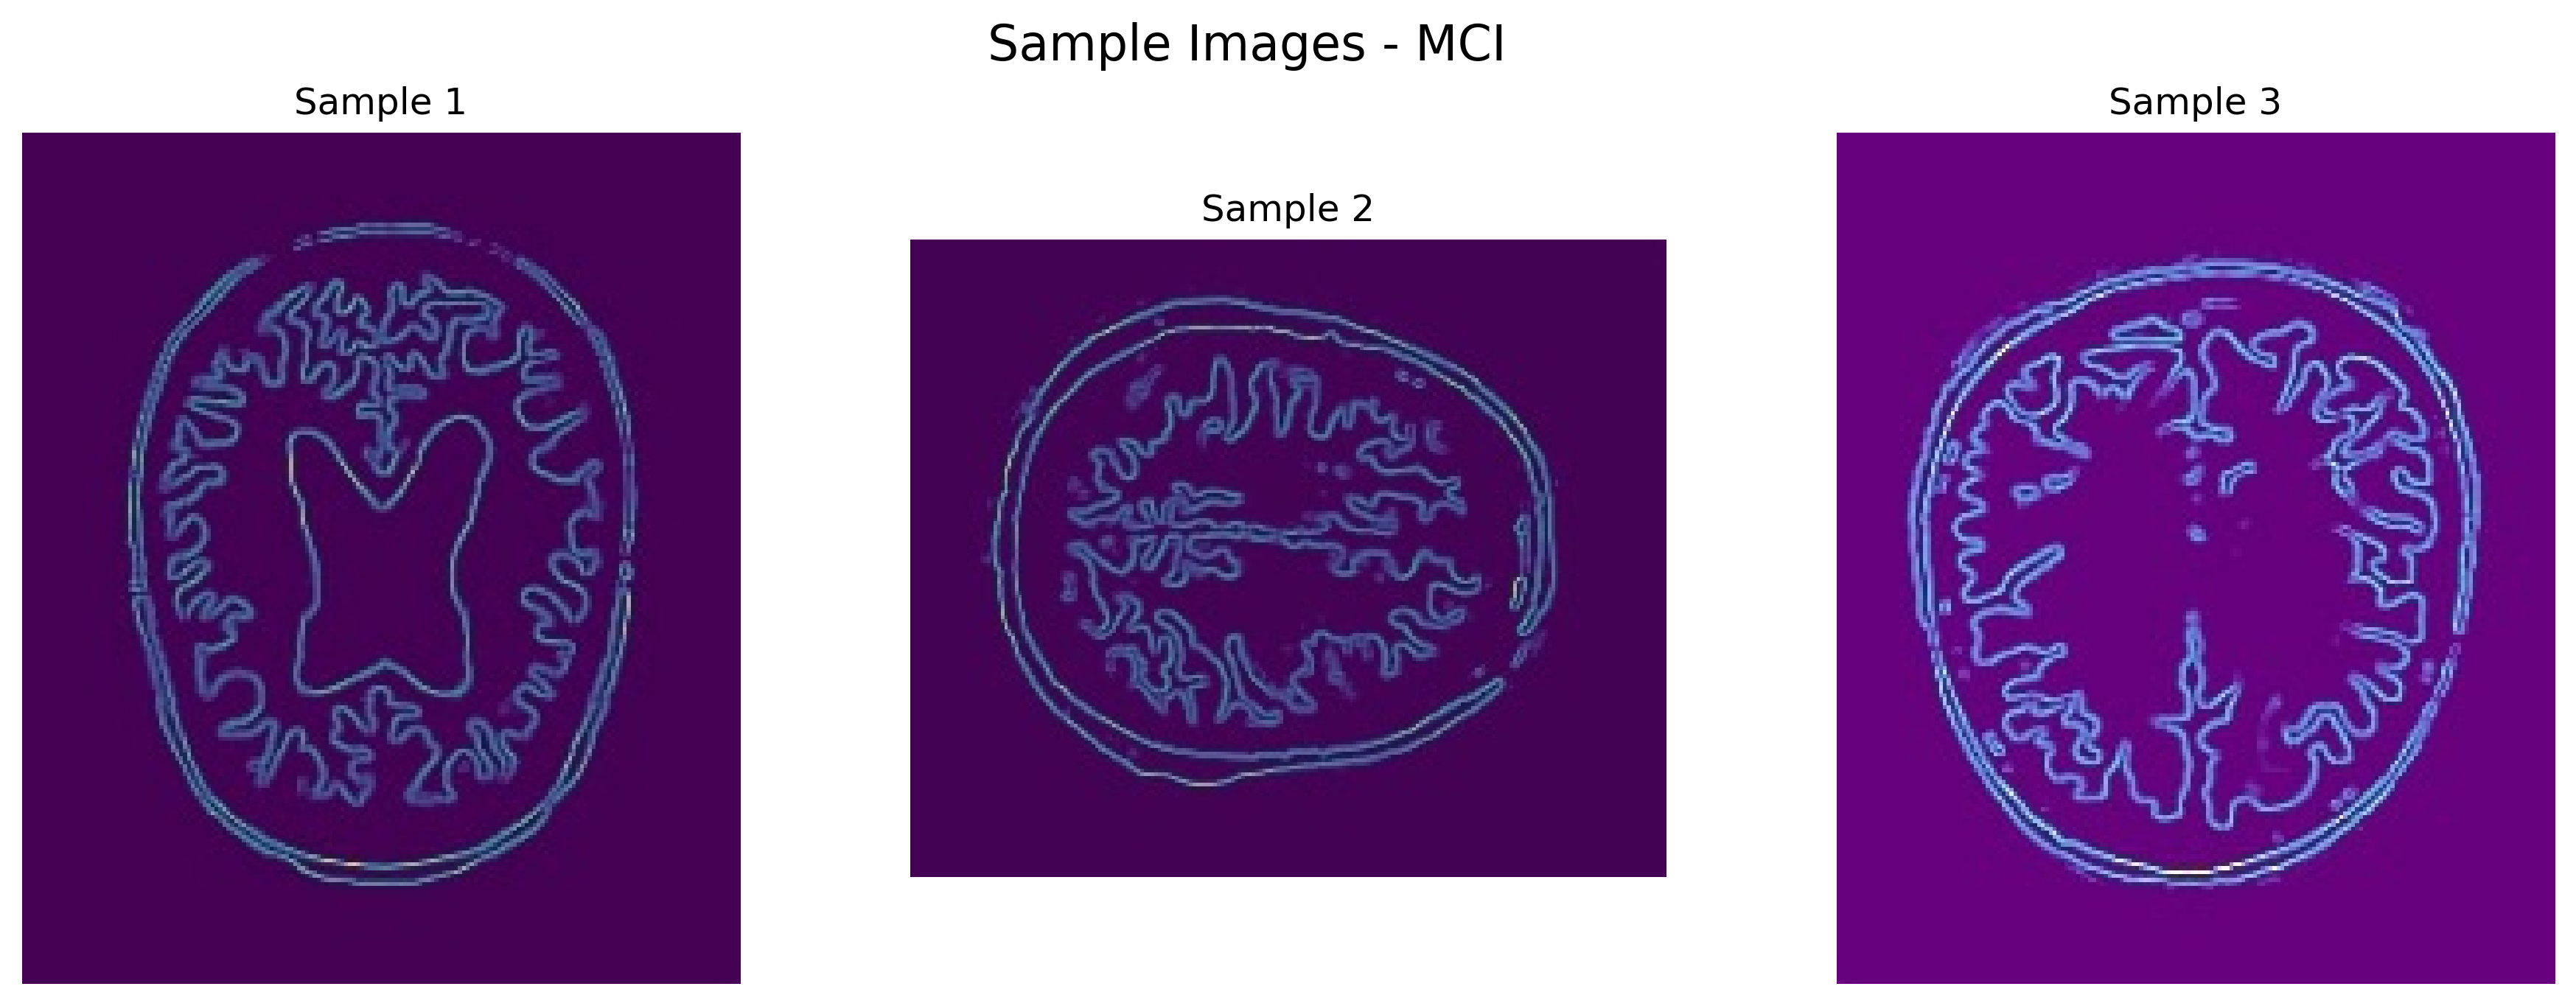

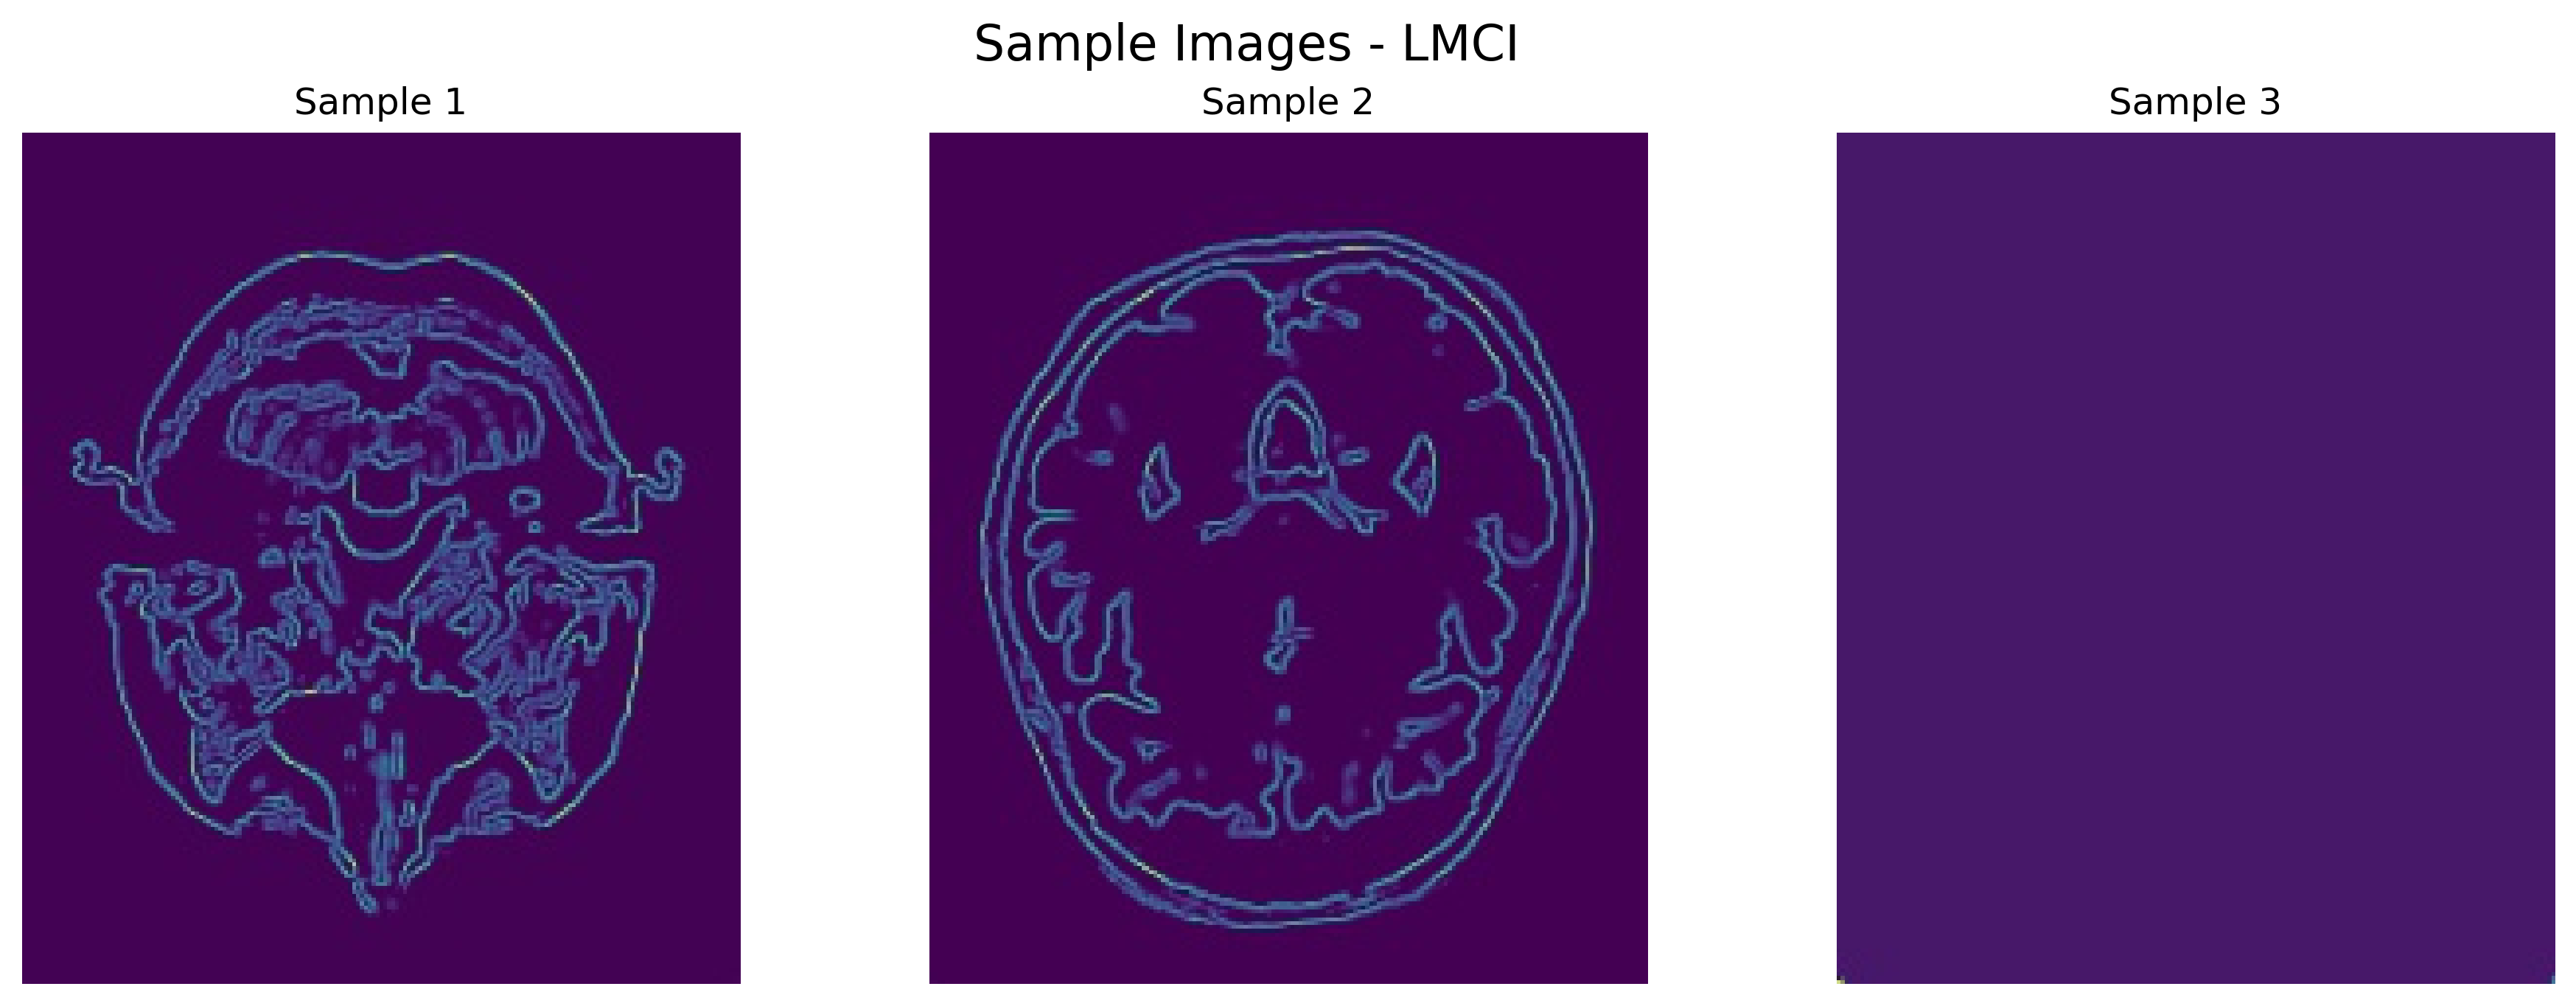

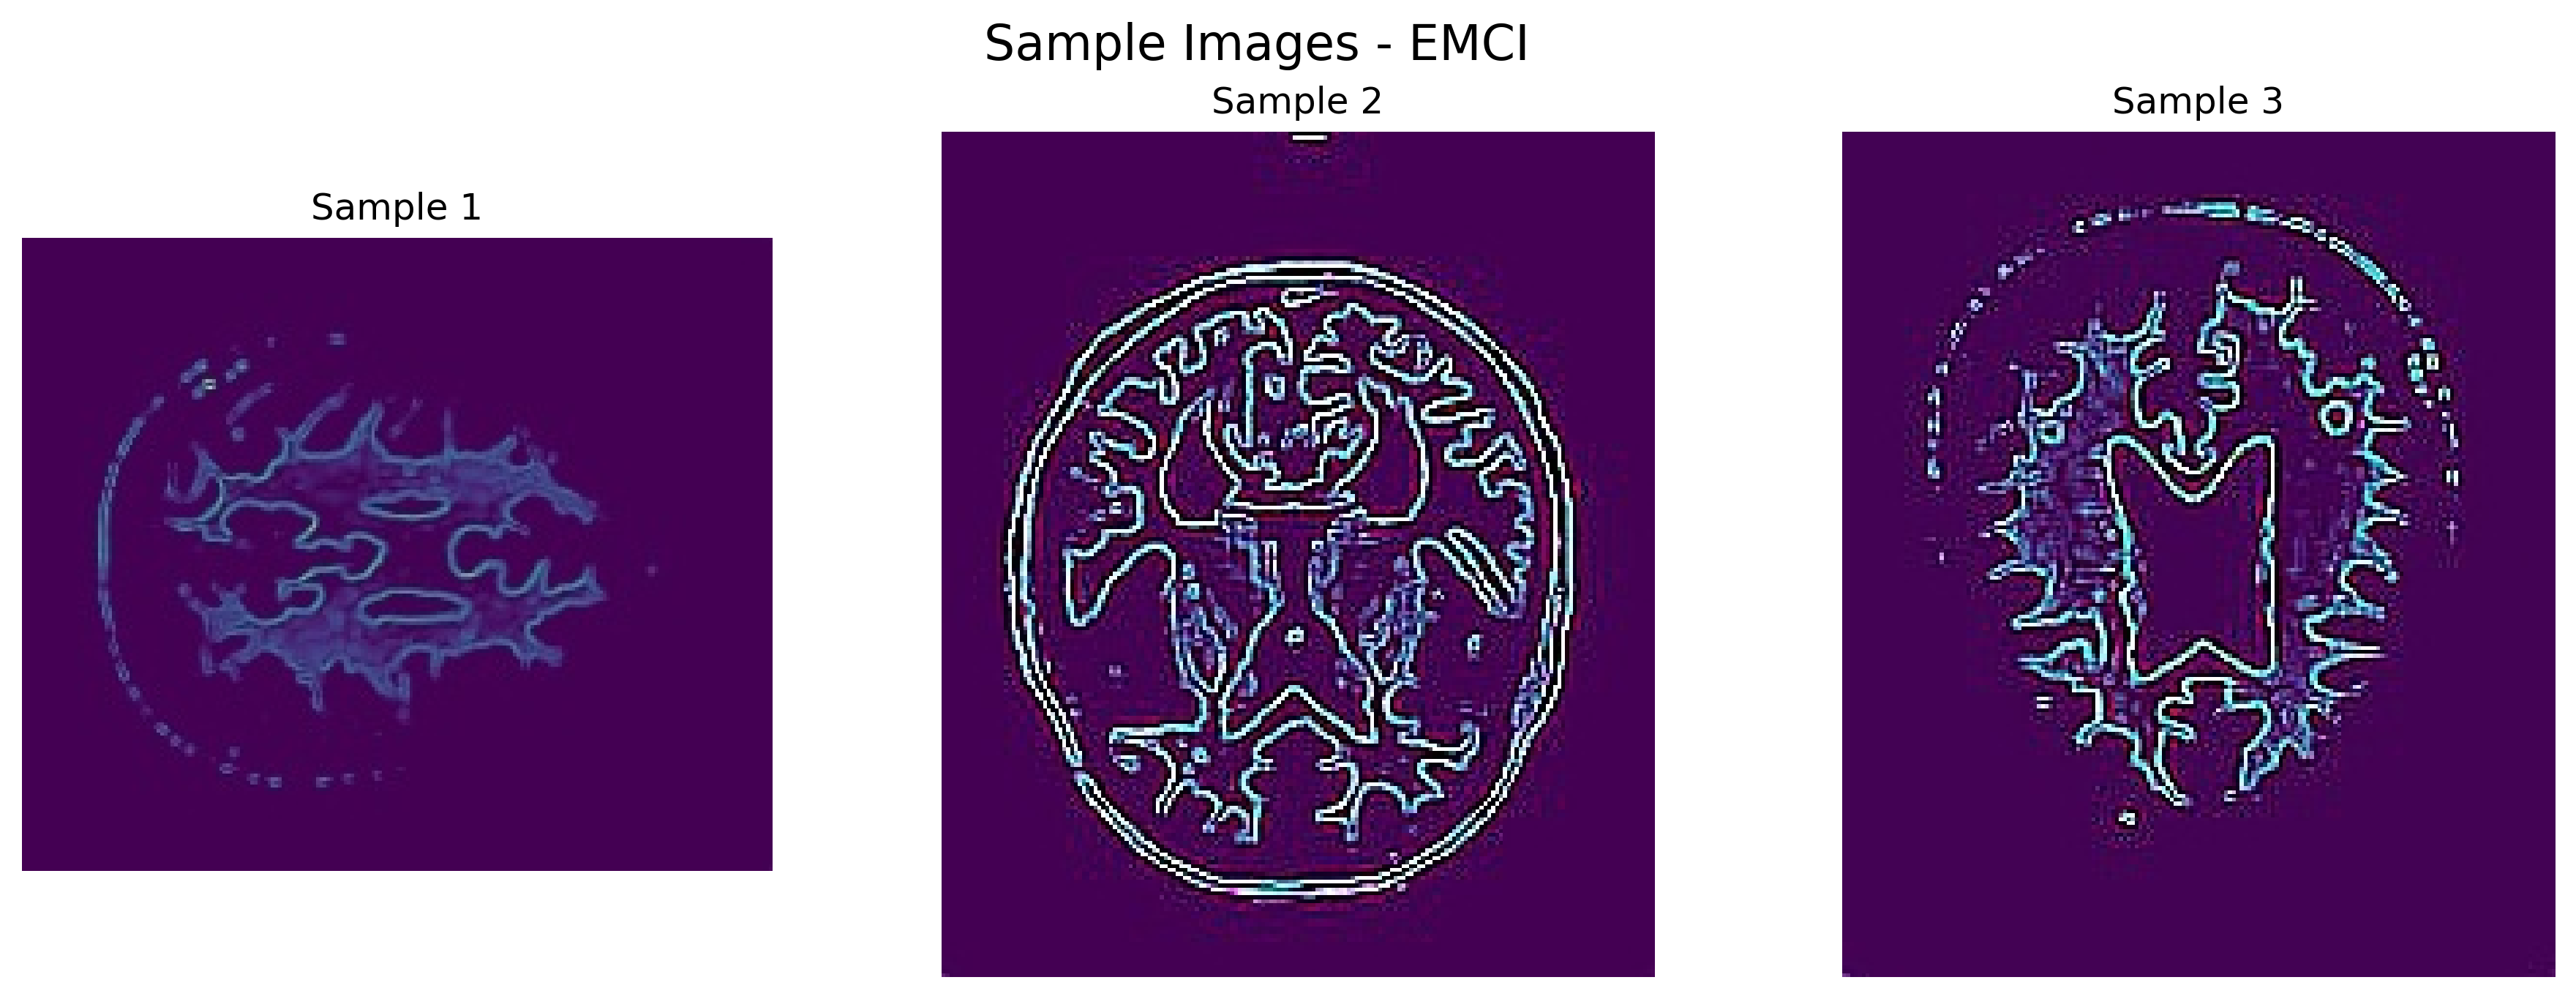

In [56]:
base_path = '/kaggle/input/cognitive/MRI_Segmented_Augmented'
categories = ['CN', 'MCI', 'LMCI', 'EMCI']
def display_sample_images(category, num_images=3):
    category_path = os.path.join(base_path, category)
    image_files = [f for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    selected_images = random.sample(image_files, num_images)
    plt.figure(figsize=(15, 5))
    for i, image_name in enumerate(selected_images):
        image_path = os.path.join(category_path, image_name)
        image = Image.open(image_path)

        plt.subplot(1, num_images, i+1)
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)
        plt.title(f'Sample {i+1}')
        plt.axis('off')

    plt.suptitle(f'Sample Images - {category}', fontsize=16)
    plt.show()
for category in categories:
    display_sample_images(category)


# Data Preprocessing

* It sets the batch size for the dataset to 32.
* Images are resized to a square shape of 128x128 pixels using the image_size parameter.
* The dataset is shuffled with shuffle=True, ensuring randomness in the order of samples.
* The seed parameter ensures reproducibility by fixing the random seed to 42.


In [57]:
dataset = tf.keras.utils.image_dataset_from_directory(base_path,
                                                batch_size = 32,
                                                image_size=(128, 128),
                                                shuffle=True,
                                                seed=42,)

class_names = dataset.class_names

Found 6906 files belonging to 4 classes.


<p style="color: black; background-color: lightsteelblue; border:2px solid black;">Pixel normalization improves the performance of a neural network. Therefore, we will go with pixel values from 0 to 1, rather than values in the range 0 to 255.</p>

In [58]:
MRI = {index: img for index, img in enumerate(dataset.class_names)}

class Process:
    def __init__(self, data):
        self.data = data.map(lambda x, y: (x/255, y))

    def create_new_batch(self):
        self.batch = self.data.as_numpy_iterator().next()
        text = "Min and max pixel values in the batch ->"
        print(text, self.batch[0].min(), "&", self.batch[0].max())

    def show_batch_images(self, number_of_images=5):
        fig, ax = plt.subplots(ncols=number_of_images, figsize=(20,20), facecolor="gray")
        fig.suptitle("Brain MRI Samples in the Batch", color="blue",fontsize=18, fontweight='bold', y=0.6)
        for idx, img in enumerate(self.batch[0][:number_of_images]):
            ax[idx].imshow(img)
            class_no = self.batch[1][idx]
            ax[idx].set_title(MRI[class_no], color="aqua")
            ax[idx].set_xticklabels([])
            ax[idx].set_yticklabels([])

    def train_test_val_split(self, train_size, val_size, test_size):

        train = int(len(self.data)*train_size)
        test = int(len(self.data)*test_size)
        val = int(len(self.data)*val_size)

        train_data = self.data.take(train)
        val_data = self.data.skip(train).take(val)
        test_data = self.data.skip(train+val).take(test)

        return train_data, val_data, test_data

Min and max pixel values in the batch -> 0.0 & 0.9775361


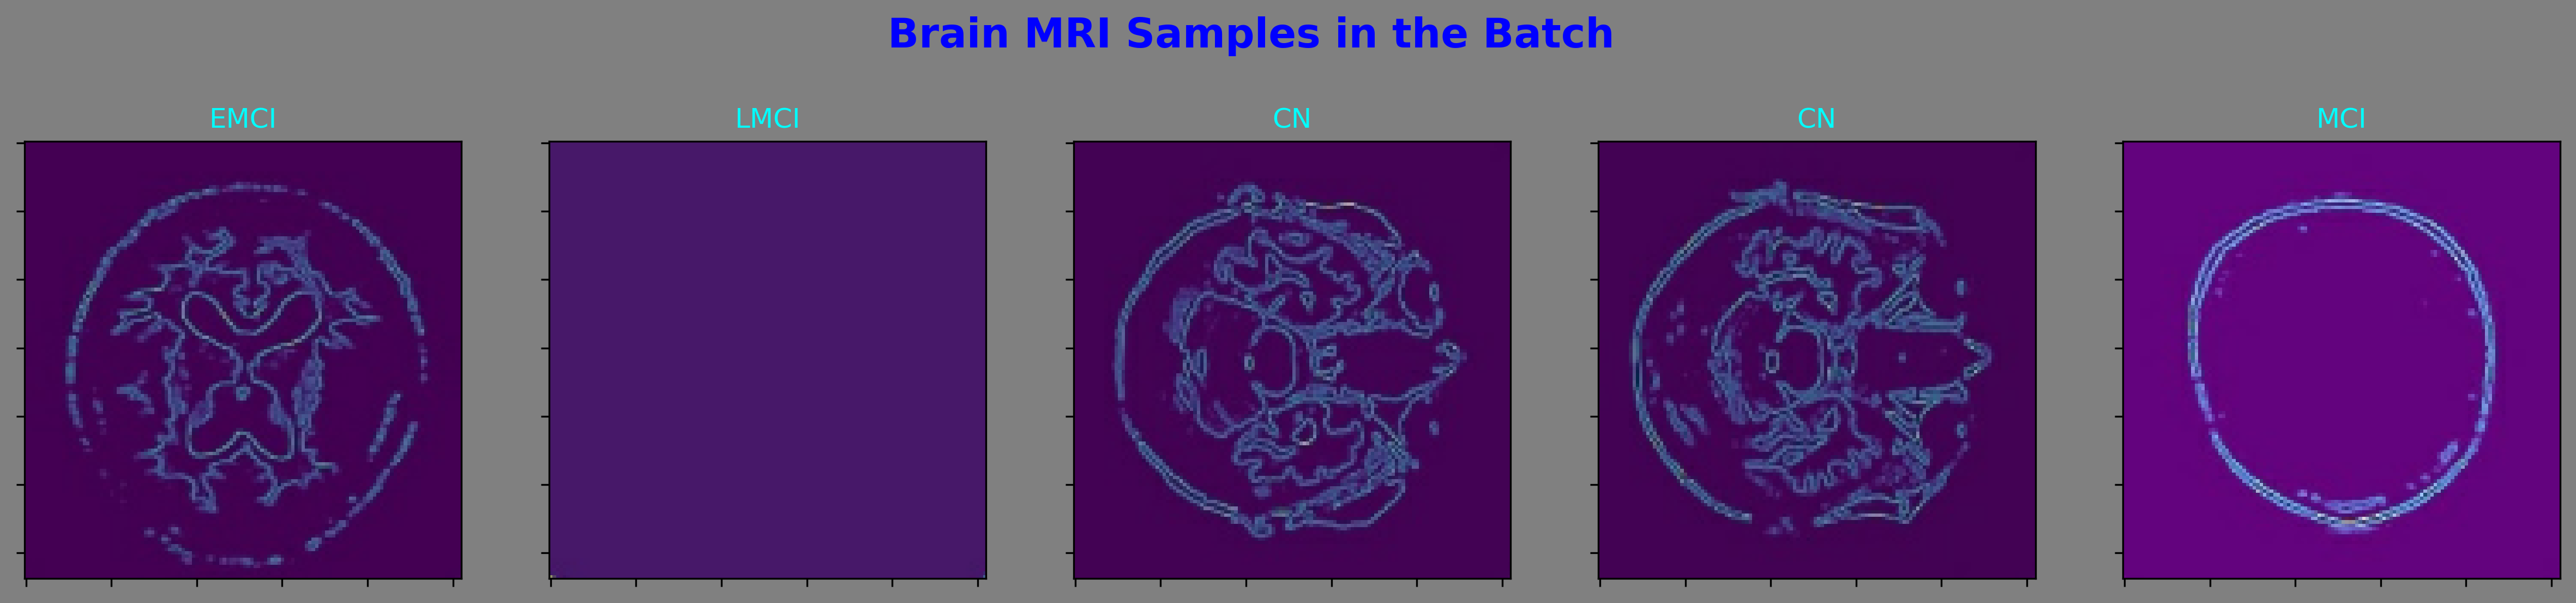

In [59]:
df = Process(dataset)
df.create_new_batch()
df.show_batch_images(number_of_images=5)

### Splitting the Data

In [60]:
train_data, val_data, test_data= df.train_test_val_split(train_size=0.8, val_size=0.1, test_size=0.1)

#### Preprocessing the Training set

To address the imbalanced distribution of target classes in our training data, we calculate class weights, which help the model better recognize minority classes, and then use these weights during model training for improved performance.

compute_class_weight function from scikit-learn is used to calculate class weights for the dataset, with the parameter 'balanced' indicating that class weights should be inversely proportional to class frequencies in the input data.

In [61]:
y_train = tf.concat(list(map(lambda x: x[1], train_data)), axis=0)
class_weight = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.numpy())
class_weights = dict(zip(np.unique(y_train), class_weight))

# Model Building

* Input Layer:
  Shape: (128, 128, 3), Represents the input image with 128x128 pixel resolution and 3 channels (RGB).
  
* Convolutional Layers:

  Conv2D (filters=16, kernel_size=(3, 3), strides=(1, 1), activation="relu"): Extracts 16 features using a 3x3 filter kernel, applies ReLU activation for non-linearity.
  MaxPooling2D (pool_size=(2, 2)): Reduces spatial dimensions by 2 in each direction using max pooling.
  
  Conv2D (filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu"): Similar to the first Conv2D but extracts 32 features.
  MaxPooling2D (pool_size=(2, 2)): Similar to the first MaxPooling2D.
  Conv2D (filters=128, kernel_size=(3, 3), strides=(1, 1), activation="relu"): Similar to the second Conv2D but extracts 128 features.
  
  MaxPooling2D (pool_size=(2, 2)): Similar to the previous MaxPooling2D.

* Fully-Connected Layers:

  Flatten(): Converts the 3D output of the last convolutional layer into a 1D vector.
  Dense (units=128, activation="relu"): Densely connected layer with 128 neurons and ReLU activation.
  Dense (units=64, activation="relu"): Similar to the previous Dense layer with 64 neurons.
  Dense (units=4, activation="softmax"): Final output layer with 4 neurons and softmax activation for 4-class classification.

* Output Layer: Probabilities for each of the 4 classes.

In [62]:
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import InceptionV3

def build_inception_model():
    input_tensor = layers.Input(shape=(128, 128, 3))

    base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)
    base_model.trainable = False

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)

    output_tensor = layers.Dense(4, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output_tensor)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

model = build_inception_model()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 63, 63,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 63, 63,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 61, 61,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 30, 30,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 30, 30,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 22,073,572 (84.20 MB)

 Trainable params: 270,788 (1.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Callbacks</h2>

In [63]:
def checkpoint_callback():
    checkpoint_filepath = '/tmp/checkpoint/model.keras'
    # Adjusted to end with '.keras'
    
    model_checkpoint_callback= ModelCheckpoint(filepath=checkpoint_filepath,
                                               save_weights_only=False,
                                               save_freq='epoch',
                                               monitor='val_accuracy',
                                               save_best_only=True,
                                               verbose=1)

    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback


EPOCHS = 30
checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=5)
callbacks = [checkpoint_callback, early_stopping]

In [64]:
history = model.fit(train_data, epochs = EPOCHS, validation_data = val_data, class_weight = class_weights, callbacks = callbacks)

Epoch 1/30
  5/172 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.2122 - loss: 2.1377 

W0000 00:00:1709968894.662957     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


170/172 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5314 - loss: 1.1246

W0000 00:00:1709968906.791104     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.71577, saving model to /tmp/checkpoint/model.keras
172/172 ━━━━━━━━━━━━━━━━━━━━ 33s 80ms/step - accuracy: 0.5331 - loss: 1.1207 - val_accuracy: 0.7158 - val_loss: 0.7010
Epoch 2/30
171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7403 - loss: 0.6512
Epoch 2: val_accuracy improved from 0.71577 to 0.78274, saving model to /tmp/checkpoint/model.keras
172/172 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.7406 - loss: 0.6507 - val_accuracy: 0.7827 - val_loss: 0.5312
Epoch 3/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7964 - loss: 0.5134
Epoch 3: val_accuracy did not improve from 0.78274
172/172 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.7965 - loss: 0.5133 - val_accuracy: 0.7783 - val_loss: 0.5551
Epoch 4/30
171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8208 - loss: 0.4641
Epoch 4: val_accuracy improved from 0.78274 to 0.82143, saving model to /tmp/checkpoint/model.keras
172/172 ━━━━━━━━━━━━━━━━━━━━ 8s 47m

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Loss and Accuracy</h2>

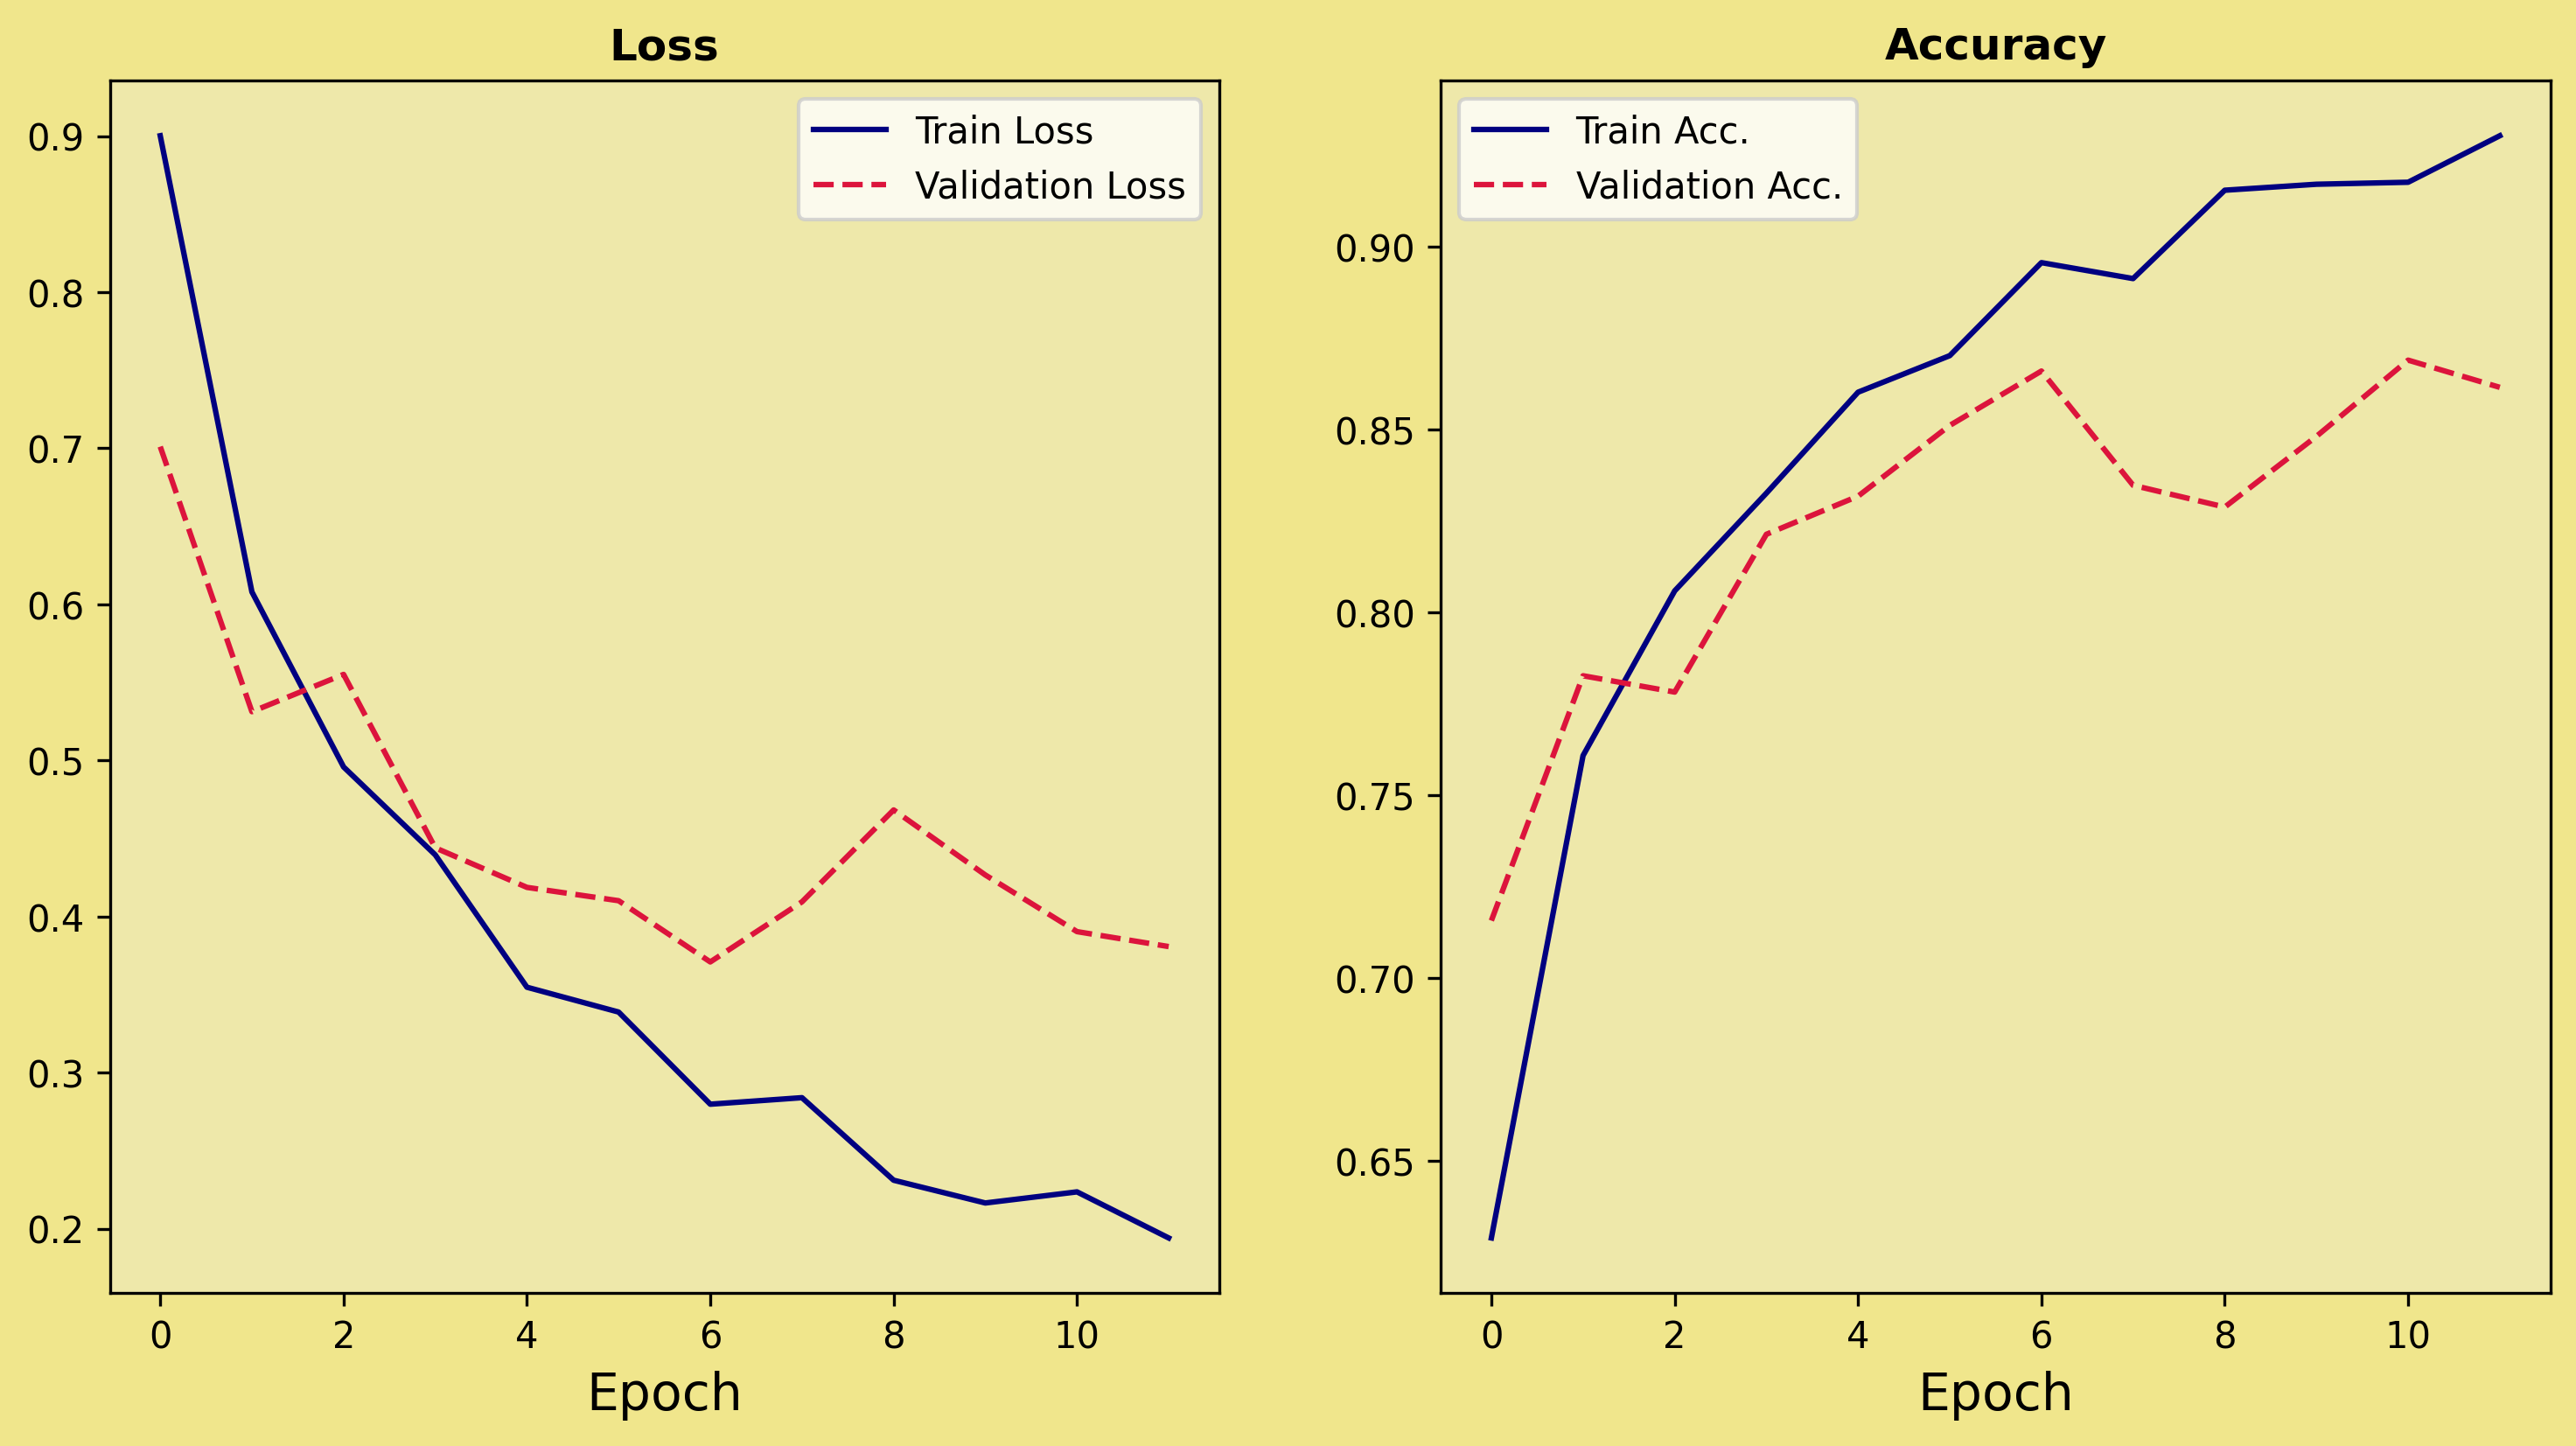

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), facecolor="khaki")
ax[0].set_facecolor('palegoldenrod')
ax[0].set_title('Loss', fontweight="bold")
ax[0].set_xlabel("Epoch", size=14)
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss", color="navy")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss", color="crimson", linestyle="dashed")
ax[0].legend()
ax[1].set_facecolor('palegoldenrod')
ax[1].set_title('Accuracy', fontweight="bold")
ax[1].set_xlabel("Epoch", size=14)
ax[1].plot(history.epoch, history.history["accuracy"], label="Train Acc.", color="navy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Acc.", color="crimson", linestyle="dashed")
ax[1].legend()

In [66]:
model.save(os.path.join('/kaggle/working/', 'inception_seg_aug_model.h5'))
print("Model saved successfully after training!")

Model saved successfully after training!


# CNN Segmented Model Prediction

In [67]:
from tensorflow.keras.models import load_model
saved_model_path = '/kaggle/working/inception_seg_aug_model.h5'
cnn_model = load_model(saved_model_path)

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Classification Report</h2>

In [68]:
predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = cnn_model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)

predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

W0000 00:00:1709969002.358261     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


              precision    recall  f1-score   support

          CN       0.78      0.85      0.81       171
        EMCI       0.92      0.71      0.80        80
        LMCI       0.84      0.99      0.91       229
         MCI       0.88      0.71      0.79       192

    accuracy                           0.84       672
   macro avg       0.86      0.82      0.83       672
weighted avg       0.85      0.84      0.84       672



<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Confusion Matrix</h2>

Text(287.16666666666663, 0.5, 'True')

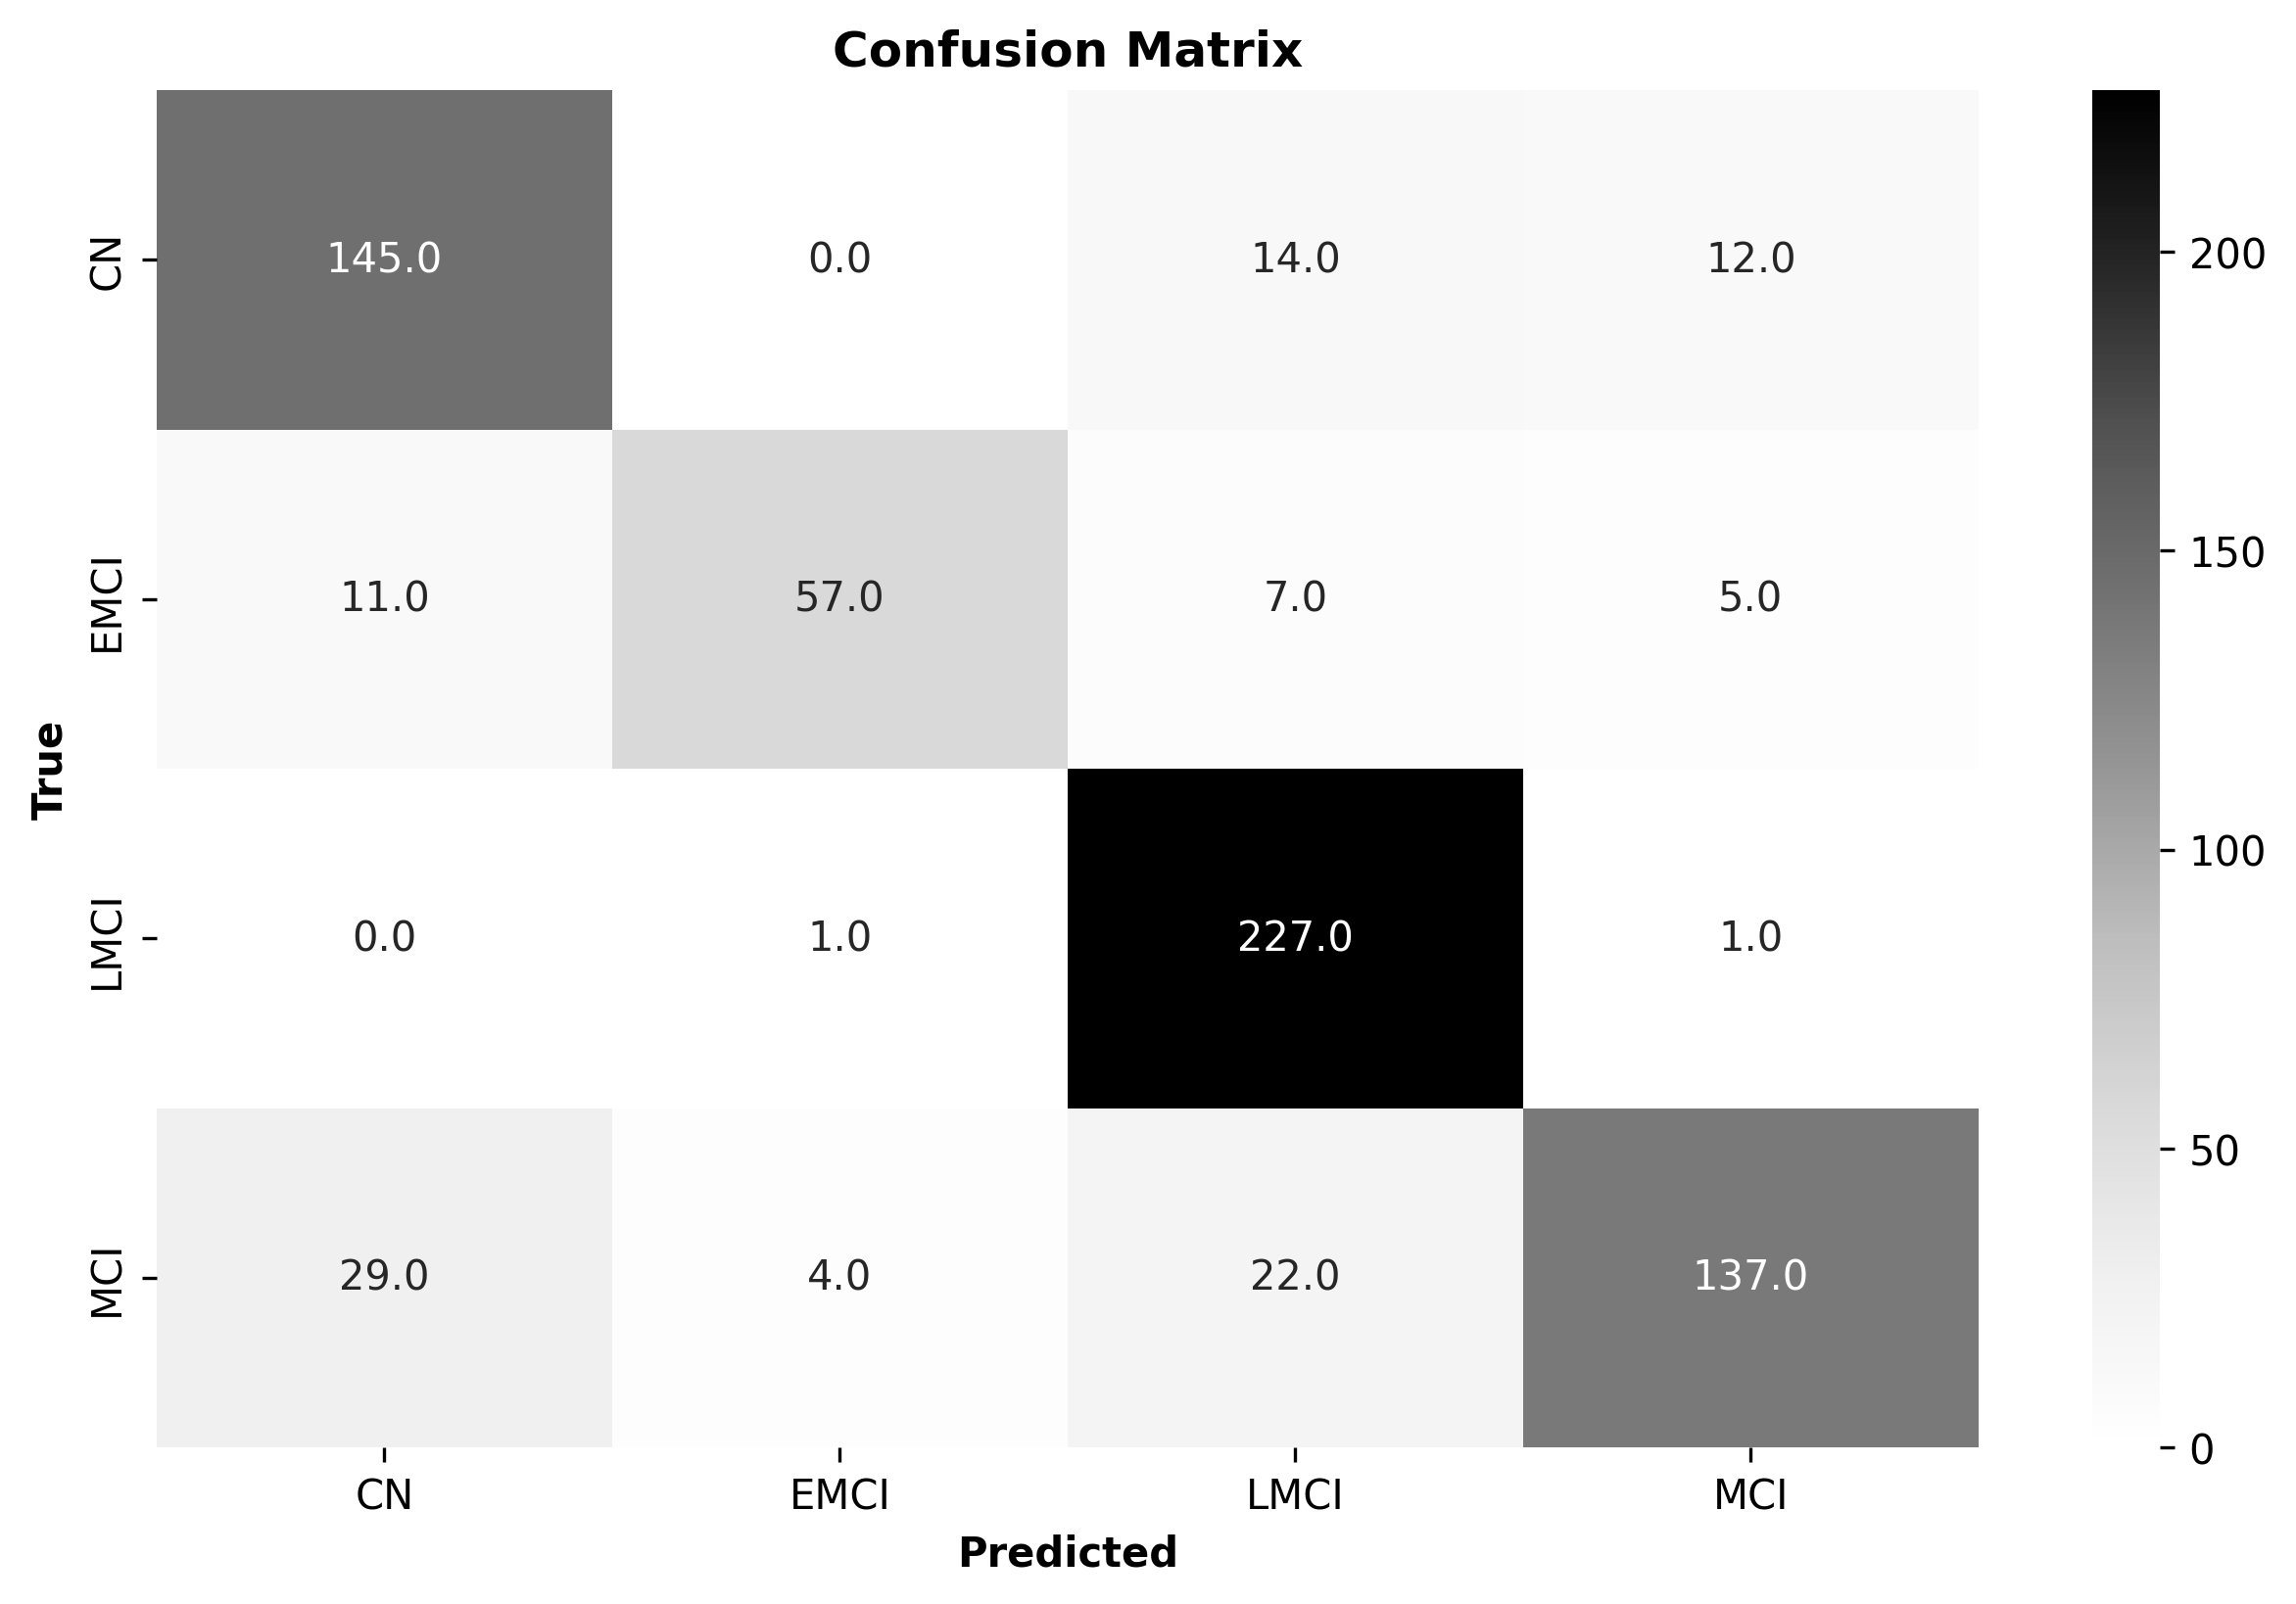

In [69]:
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df
plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Greys", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")

<p style="color: black; background-color: lightsteelblue; border:2px solid black;">
Let's create a function that fetches a random image and displays a pie chart showing the probability distribution of which target value the image belongs to, represented as percentages. In this way, it will be seen which class the model gives the highest probability to.</p>

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Cognitive Probability of a Random MRI from Test Data</h2>

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


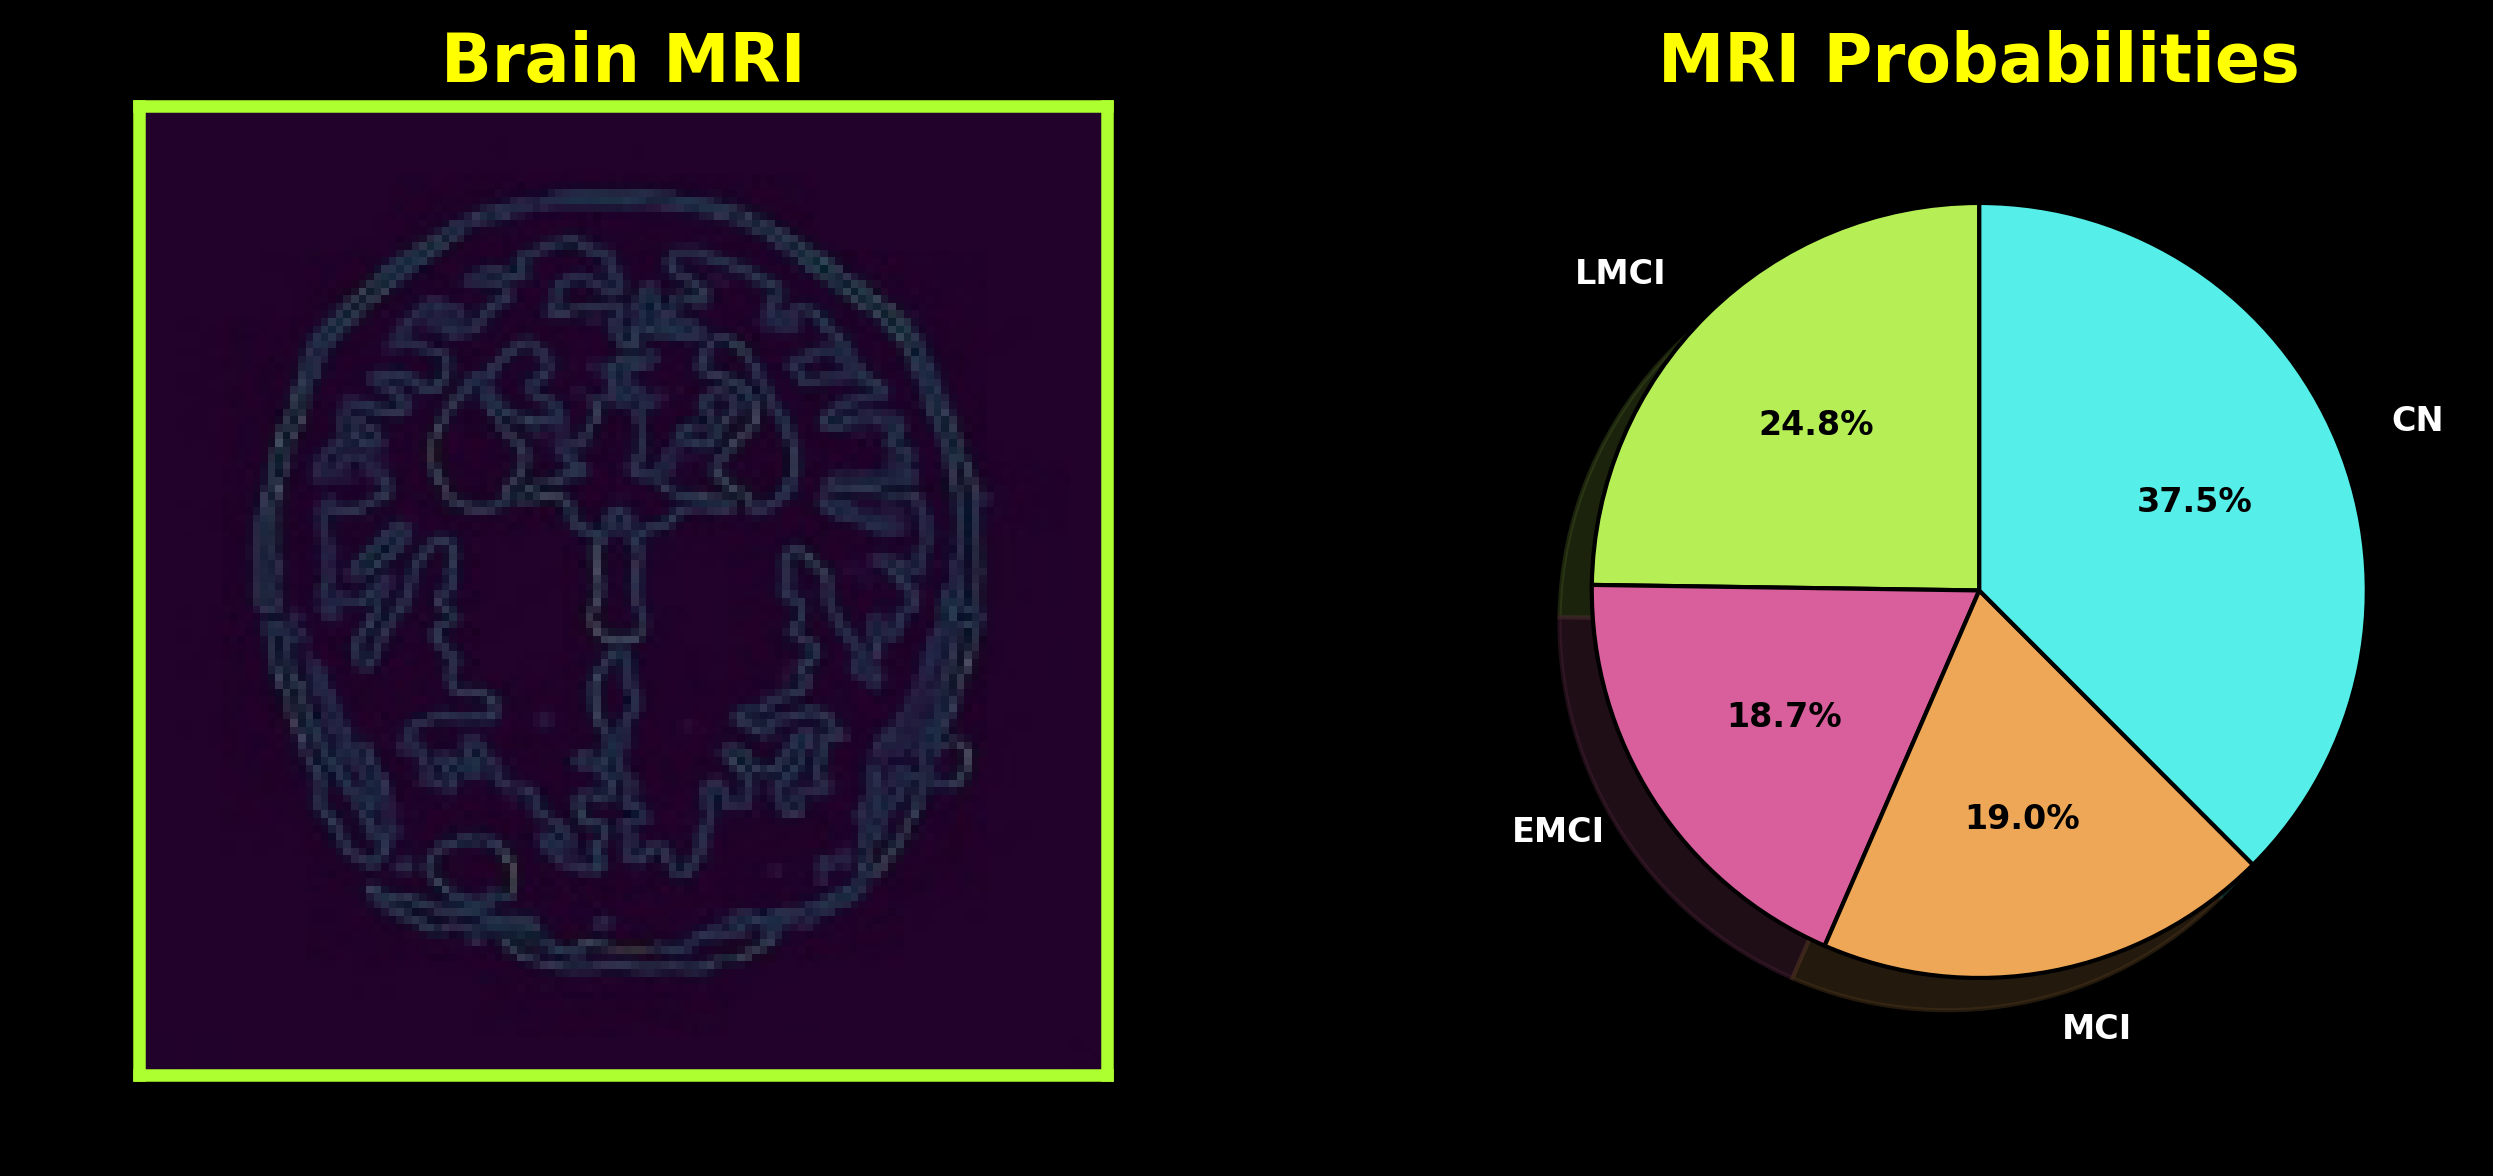

In [70]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]
def random_mri_prob_bringer(image_number=0):

    for images, _ in test_data.skip(5).take(1):
        image = images[image_number]
        pred = cnn_model.predict(tf.expand_dims(image, 0))[0]

    probs = list(tf.nn.softmax(pred).numpy())
    probs_dict = dict(zip(class_dist.keys(), probs))

    keys = list(probs_dict.keys())
    values = list(probs_dict.values())

    fig, (ax1, ax2) = plt.subplots(1, 2, facecolor='black')
    plt.subplots_adjust(wspace=0.4)
    ax1.imshow(image)
    ax1.set_title('Brain MRI', color="yellow", fontweight="bold", fontsize=16)

    edges = ['left', 'bottom', 'right', 'top']
    edge_color = "greenyellow"
    edge_width = 3
    for edge in edges:
        ax1.spines[edge].set_linewidth(edge_width)
        ax1.spines[edge].set_edgecolor(edge_color)

    plt.gca().axes.yaxis.set_ticklabels([])
    plt.gca().axes.xaxis.set_ticklabels([])

    wedges, labels, autopct = ax2.pie(values, labels=keys,  autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors, textprops={'fontsize': 8, "fontweight":"bold", "color":"white"},  wedgeprops=
       {'edgecolor':'black'} , labeldistance=1.15)

    for autotext in autopct:
        autotext.set_color('black')

    ax2.set_title('MRI Probabilities', color="yellow", fontweight="bold", fontsize=16)

rand_img_no = np.random.randint(1, 32)
random_mri_prob_bringer(image_number=rand_img_no)

<p style="color: black; background-color: lightsteelblue; border:2px solid black;">
Now, let's see the actual classes and predicted classes of these samples by bringing samples from our test data.</p>

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Comparing Predicted Classes with the Actual Classes from the Test Data</h2>

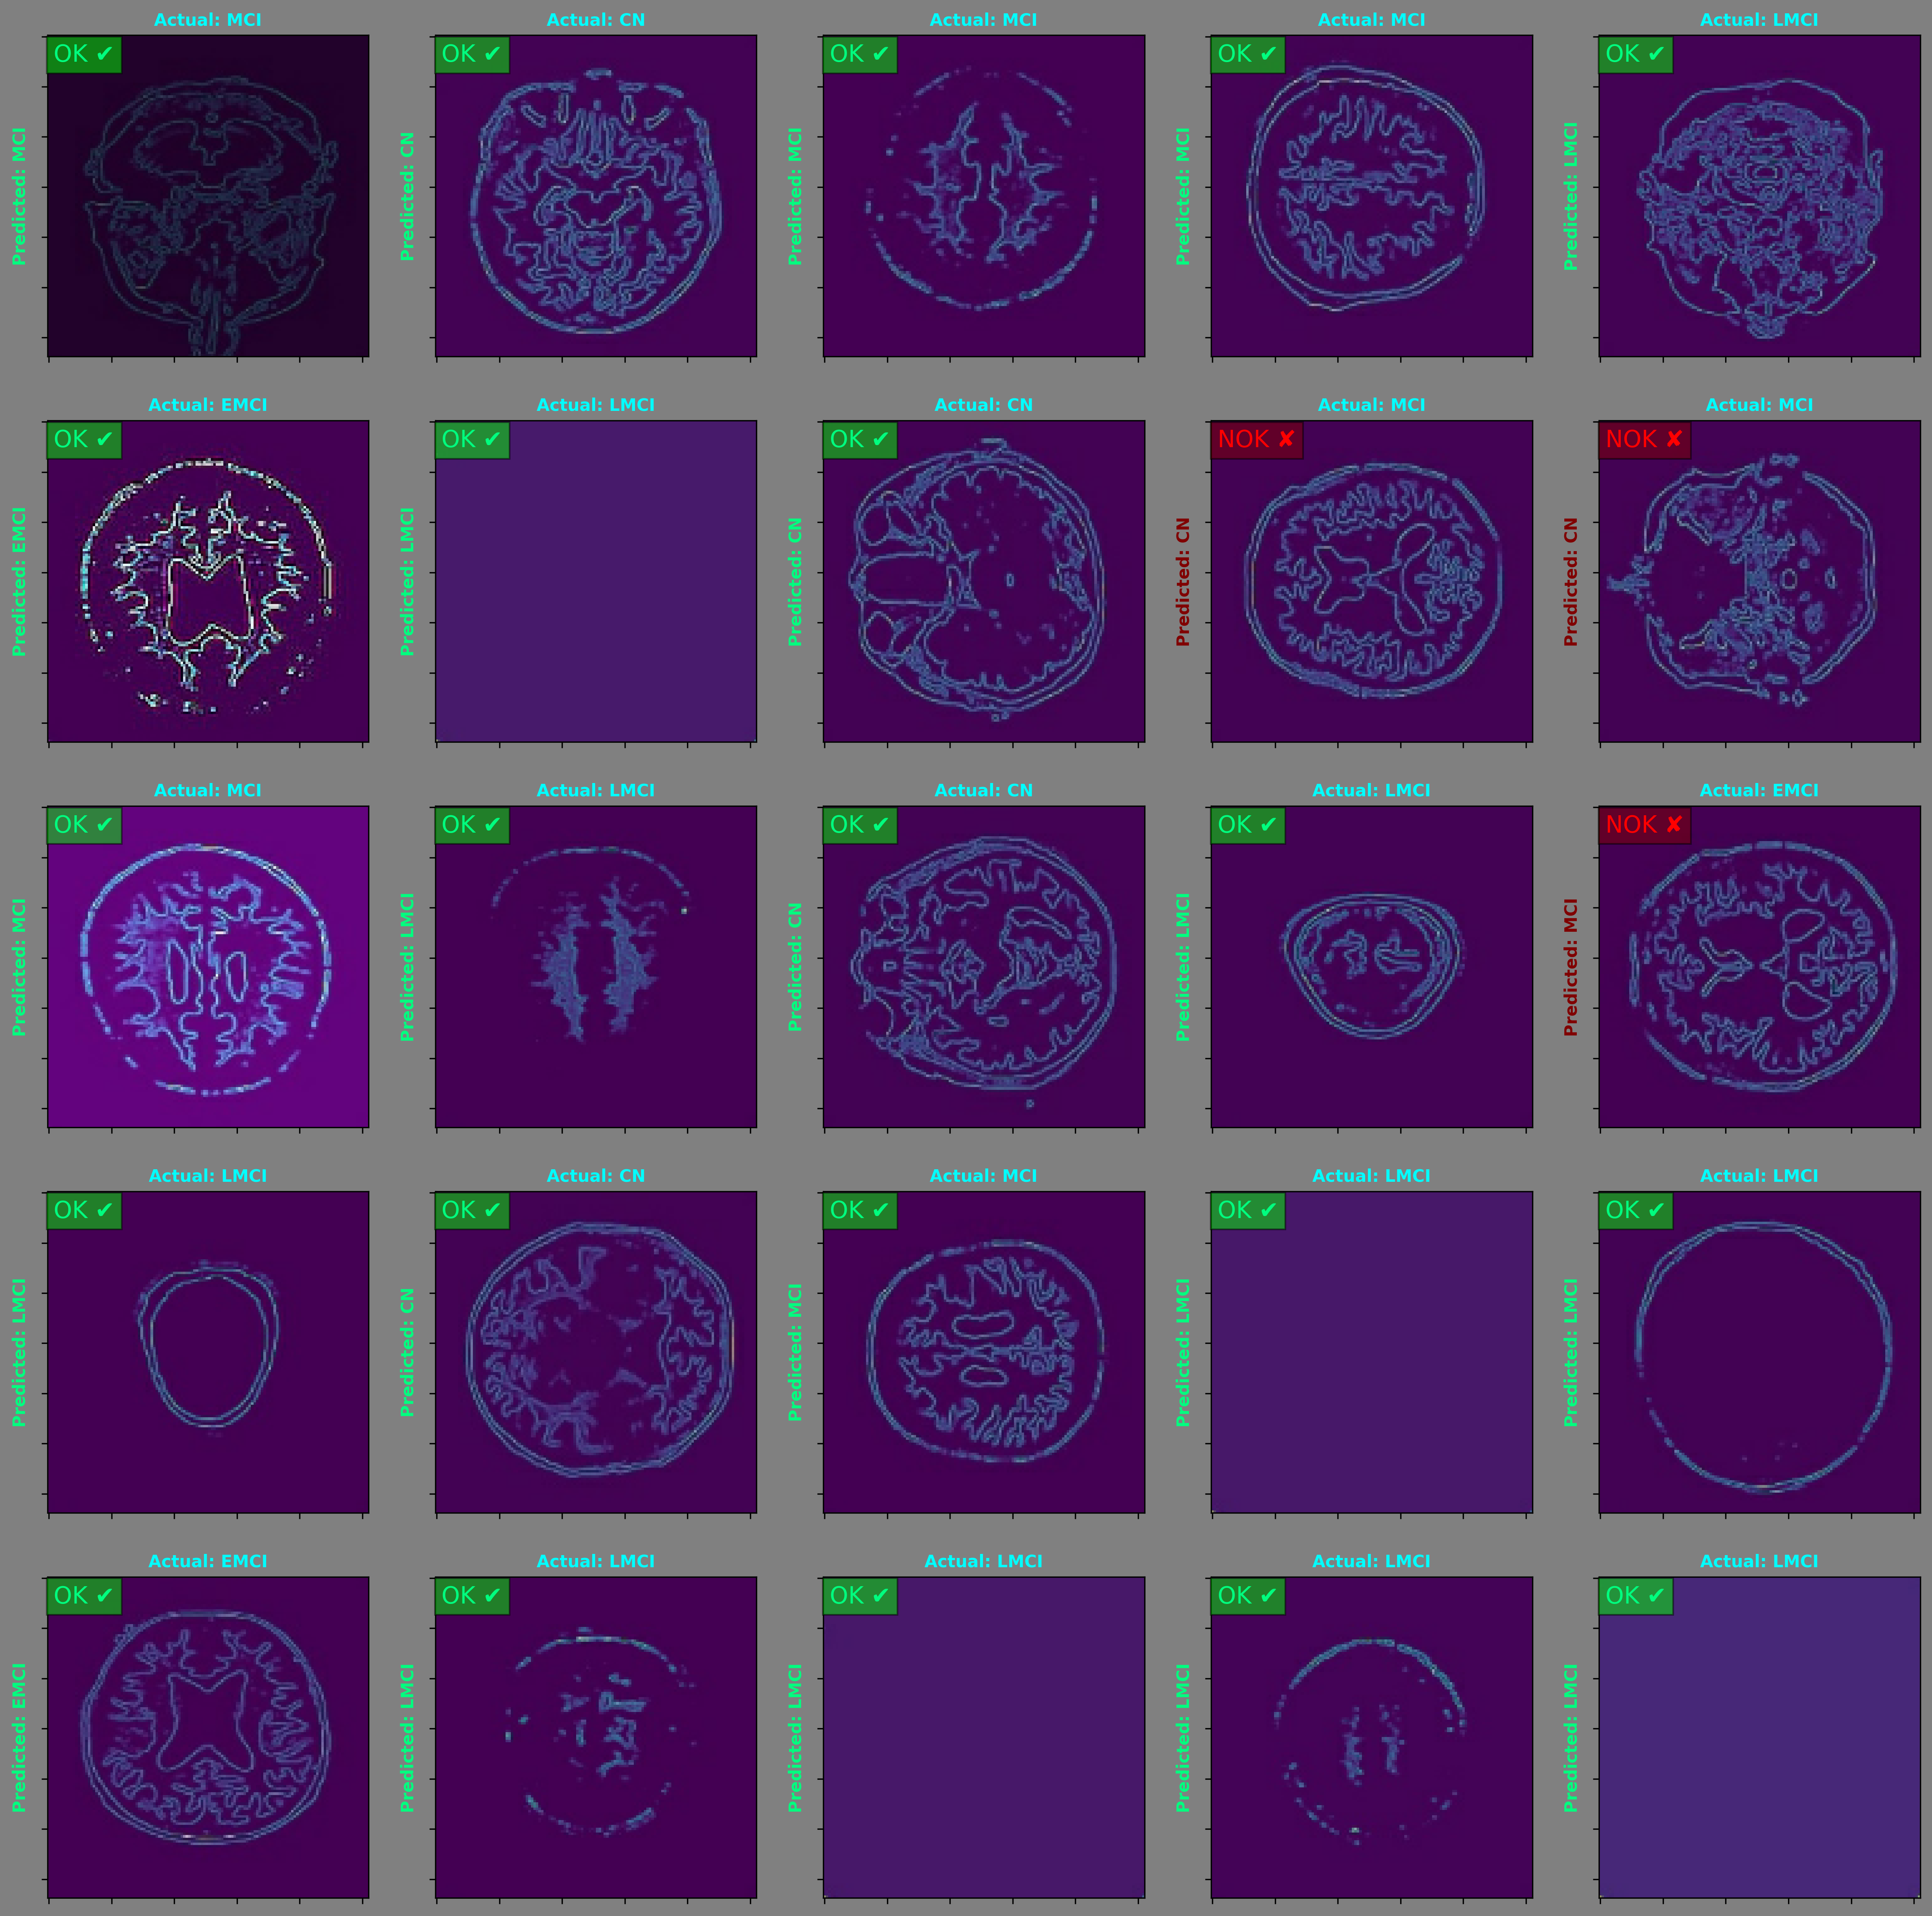

In [71]:
plt.figure(figsize=(20, 20), facecolor="gray")
for images, labels in test_data.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        predictions = cnn_model.predict(tf.expand_dims(images[i], 0), verbose=0)
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="springgreen", fontweight="bold", fontsize=10)
            ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=14)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))

        else:
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="maroon", fontweight="bold", fontsize=10)
            nok_text = plt.text(2, 10, "NOK \u2718", color="red", fontsize=14)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])

# Feature Extraction

In [72]:
import os
import numpy as np
import tensorflow as tf
from keras.models import load_model

# Load the pre-trained model
model = load_model('/kaggle/working/inception_seg_aug_model.h5')

# Define the base path to the directory containing the images
base_path = "/kaggle/input/cognitive/MRI_Segmented_Augmented"

# Create a dataset from the directory
dataset = tf.keras.utils.image_dataset_from_directory(
    base_path,
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42
)

# Extract features from the dataset using the pre-trained model
features_list = []
labels_list = []

for images, labels in dataset:
    # Preprocess images if necessary (already resized by image_dataset_from_directory)
    # Perform prediction to extract features
    features = model.predict(images)
    
    # Append features and labels to lists
    features_list.append(features)
    labels_list.append(labels)

# Concatenate features and labels into numpy arrays
features_array = np.concatenate(features_list, axis=0)
labels_array = np.concatenate(labels_list, axis=0)


Found 6906 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


W0000 00:00:1709969034.149472     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

W0000 00:00:1709969066.376707     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [73]:
# Assuming features_array contains the extracted features
sample_size = 5  # Define the number of samples to print
print("Sample features:")
for i in range(sample_size):
    print(f"Sample {i+1}: {features_array[i]}")


Sample features:
Sample 1: [5.5497932e-20 3.8573852e-08 9.9930108e-01 6.9883483e-04]
Sample 2: [0.0000000e+00 1.0000000e+00 4.9045446e-44 2.0673193e-24]
Sample 3: [4.3212248e-23 5.3147350e-14 1.0000000e+00 1.3250560e-10]
Sample 4: [8.8095233e-25 4.0941525e-10 9.9999988e-01 1.7191898e-07]
Sample 5: [0.0000000e+00 3.8150036e-01 4.5348175e-10 6.1849964e-01]


In [74]:
# Assuming labels_array contains the labels corresponding to the extracted features
sample_size = 5  # Define the number of samples to print
print("Sample labels:")
for i in range(sample_size):
    print(f"Sample {i+1} - Label: {labels_array[i]}, Features: {features_array[i]}")


Sample labels:
Sample 1 - Label: 1, Features: [5.5497932e-20 3.8573852e-08 9.9930108e-01 6.9883483e-04]
Sample 2 - Label: 2, Features: [0.0000000e+00 1.0000000e+00 4.9045446e-44 2.0673193e-24]
Sample 3 - Label: 0, Features: [4.3212248e-23 5.3147350e-14 1.0000000e+00 1.3250560e-10]
Sample 4 - Label: 0, Features: [8.8095233e-25 4.0941525e-10 9.9999988e-01 1.7191898e-07]
Sample 5 - Label: 3, Features: [0.0000000e+00 3.8150036e-01 4.5348175e-10 6.1849964e-01]


In [75]:
# Define label categories
label_categories = ['CN', 'MCI', 'LMCI', 'EMCI']

# Map integer labels to corresponding categories
mapped_labels = [label_categories[label] for label in labels_array]

# Print sample labels
sample_size = 5  # Define the number of samples to print
print("Sample labels:")
for i in range(sample_size):
    print(f"Sample {i+1} - Label: {mapped_labels[i]}, Features: {features_array[i]}")


Sample labels:
Sample 1 - Label: MCI, Features: [5.5497932e-20 3.8573852e-08 9.9930108e-01 6.9883483e-04]
Sample 2 - Label: LMCI, Features: [0.0000000e+00 1.0000000e+00 4.9045446e-44 2.0673193e-24]
Sample 3 - Label: CN, Features: [4.3212248e-23 5.3147350e-14 1.0000000e+00 1.3250560e-10]
Sample 4 - Label: CN, Features: [8.8095233e-25 4.0941525e-10 9.9999988e-01 1.7191898e-07]
Sample 5 - Label: EMCI, Features: [0.0000000e+00 3.8150036e-01 4.5348175e-10 6.1849964e-01]


In [76]:
import pandas as pd

# Combine features and labels into a DataFrame
df = pd.DataFrame(features_array, columns=[f"feature_{i}" for i in range(features_array.shape[1])])
df['label'] = mapped_labels  # Add labels column

# Define the path to save the CSV file
csv_path = "/kaggle/working/inception-seg-aug.csv"

# Save the DataFrame as a CSV file
df.to_csv(csv_path, index=False)

print(f"CSV file saved at: {csv_path}")

CSV file saved at: /kaggle/working/inception-seg-aug.csv
